# Notebook 01: Ames Exploratory Analysis

Comprehensive exploratory data analysis (EDA) for the Ames Housing Dataset.
Focus: Understanding features, relationships, and distributions specific to USA market.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [17]:
ames_data = pd.read_csv('data/ames/AmesHousing.csv')

print("Ames Dataset Overview:")
print(f"Shape: {ames_data.shape}")
print(f"Columns: {len(ames_data.columns)} features")

Ames Dataset Overview:
Shape: (2930, 82)
Columns: 82 features


## Dataset Info

In [18]:
print("Data Types Distribution:")
print(ames_data.dtypes.value_counts())
print(f"\nNumerical features: {ames_data.select_dtypes(include=[np.number]).shape}")
print(f"Categorical features: {ames_data.select_dtypes(include=['object']).shape}")
print(f"\nDuplicate rows: {ames_data.duplicated().sum()}")
print(f"Unique IDs: {ames_data['PID'].nunique()} out of {len(ames_data)}")

Data Types Distribution:
object     43
int64      28
float64    11
Name: count, dtype: int64

Numerical features: (2930, 39)
Categorical features: (2930, 43)

Duplicate rows: 0
Unique IDs: 2930 out of 2930


## Target Variable Analysis

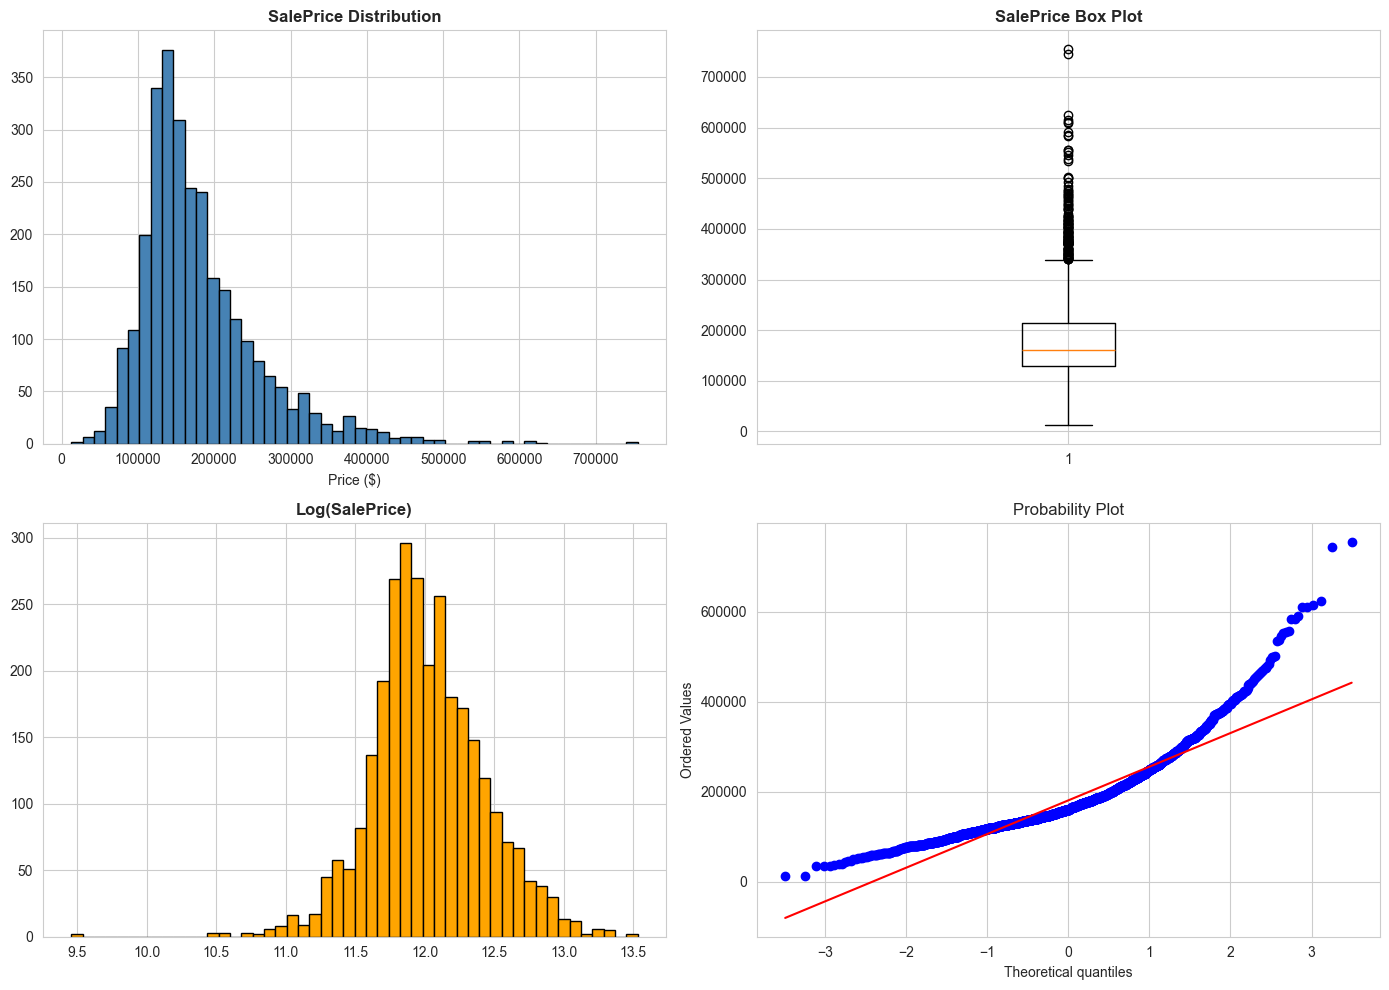

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution
axes[0, 0].hist(ames_data['SalePrice'], bins=50, edgecolor='black', color='steelblue')
axes[0, 0].set_title('SalePrice Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Price ($)')

# Box plot
axes[0, 1].boxplot(ames_data['SalePrice'])
axes[0, 1].set_title('SalePrice Box Plot', fontweight='bold')

# Log-transformed
axes[1, 0].hist(np.log1p(ames_data['SalePrice']), bins=50, edgecolor='black', color='orange')
axes[1, 0].set_title('Log(SalePrice)', fontweight='bold')

# Q-Q plot
stats.probplot(ames_data['SalePrice'], dist="norm", plot=axes[1, 1])

plt.tight_layout()
plt.show()

print(ames_data['SalePrice'].describe())

The histogram shows that house prices are right-skewed, meaning most properties are affordable (under $200k), whilst a few expensive homes create a long tail to the right. The Probability Plot confirms that applying a 'Log Transformation' successfully fixes this skew, making the data suitable for machine learning models.

## Missing Values Analysis

Top 20 Missing Values:
                        Column  Missing_Count  Missing_Percentage
Pool QC                Pool QC           2917           99.556314
Misc Feature      Misc Feature           2824           96.382253
Alley                    Alley           2732           93.242321
Fence                    Fence           2358           80.477816
Mas Vnr Type      Mas Vnr Type           1775           60.580205
Fireplace Qu      Fireplace Qu           1422           48.532423
Lot Frontage      Lot Frontage            490           16.723549
Garage Cond        Garage Cond            159            5.426621
Garage Finish    Garage Finish            159            5.426621
Garage Yr Blt    Garage Yr Blt            159            5.426621
Garage Qual        Garage Qual            159            5.426621
Garage Type        Garage Type            157            5.358362
Bsmt Exposure    Bsmt Exposure             83            2.832765
BsmtFin Type 2  BsmtFin Type 2             81        

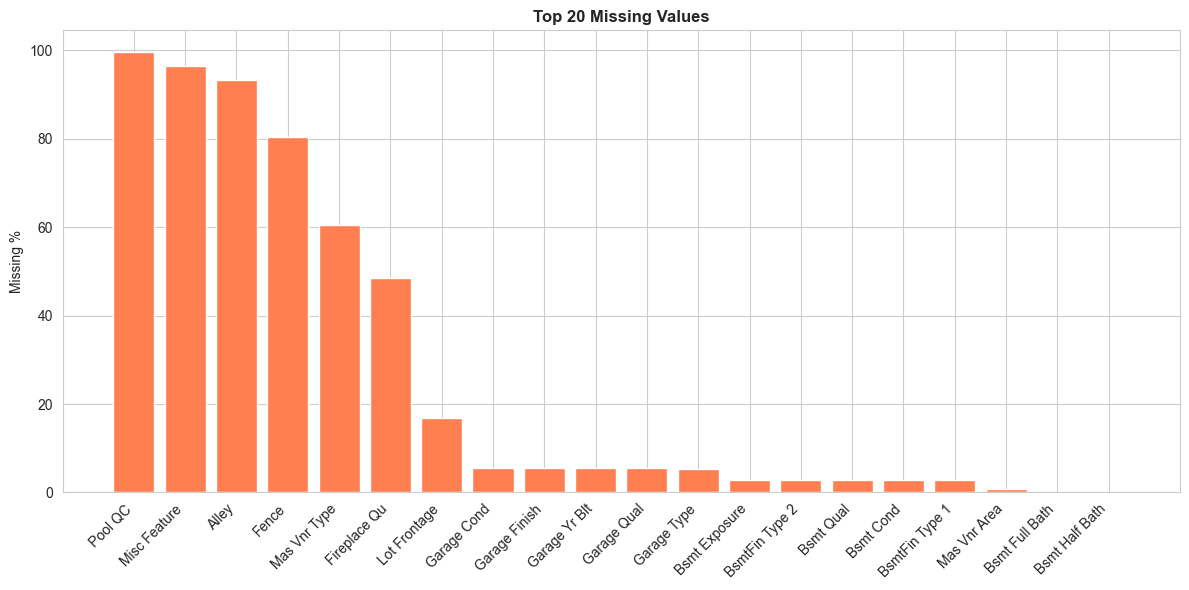

In [20]:
missing = pd.DataFrame({
    'Column': ames_data.columns,
    'Missing_Count': ames_data.isnull().sum(),
    'Missing_Percentage': (ames_data.isnull().sum() / len(ames_data)) * 100
}).sort_values('Missing_Percentage', ascending=False)

print("Top 20 Missing Values:")
print(missing.head(20))

# Visualize
plt.figure(figsize=(12, 6))
plt.bar(missing.head(20)['Column'], missing.head(20)['Missing_Percentage'], color='coral')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Missing Values', fontweight='bold')
plt.ylabel('Missing %')
plt.tight_layout()
plt.show()

This chart highlights that features like 'Pool Quality', 'Misc Feature', and 'Alley' are missing in over 90% of records. This confirms that 'NaN' in this dataset typically means the house simply lacks that feature (e.g. no pool), rather than the data being lost.

## Numerical Features Correlation

Total numerical features (excluding target): 37

Top 15 Correlations with SalePrice:
SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Garage Yr Blt     0.526965
Mas Vnr Area      0.508285
TotRms AbvGrd     0.495474
Fireplaces        0.474558
BsmtFin SF 1      0.432914
Name: SalePrice, dtype: float64


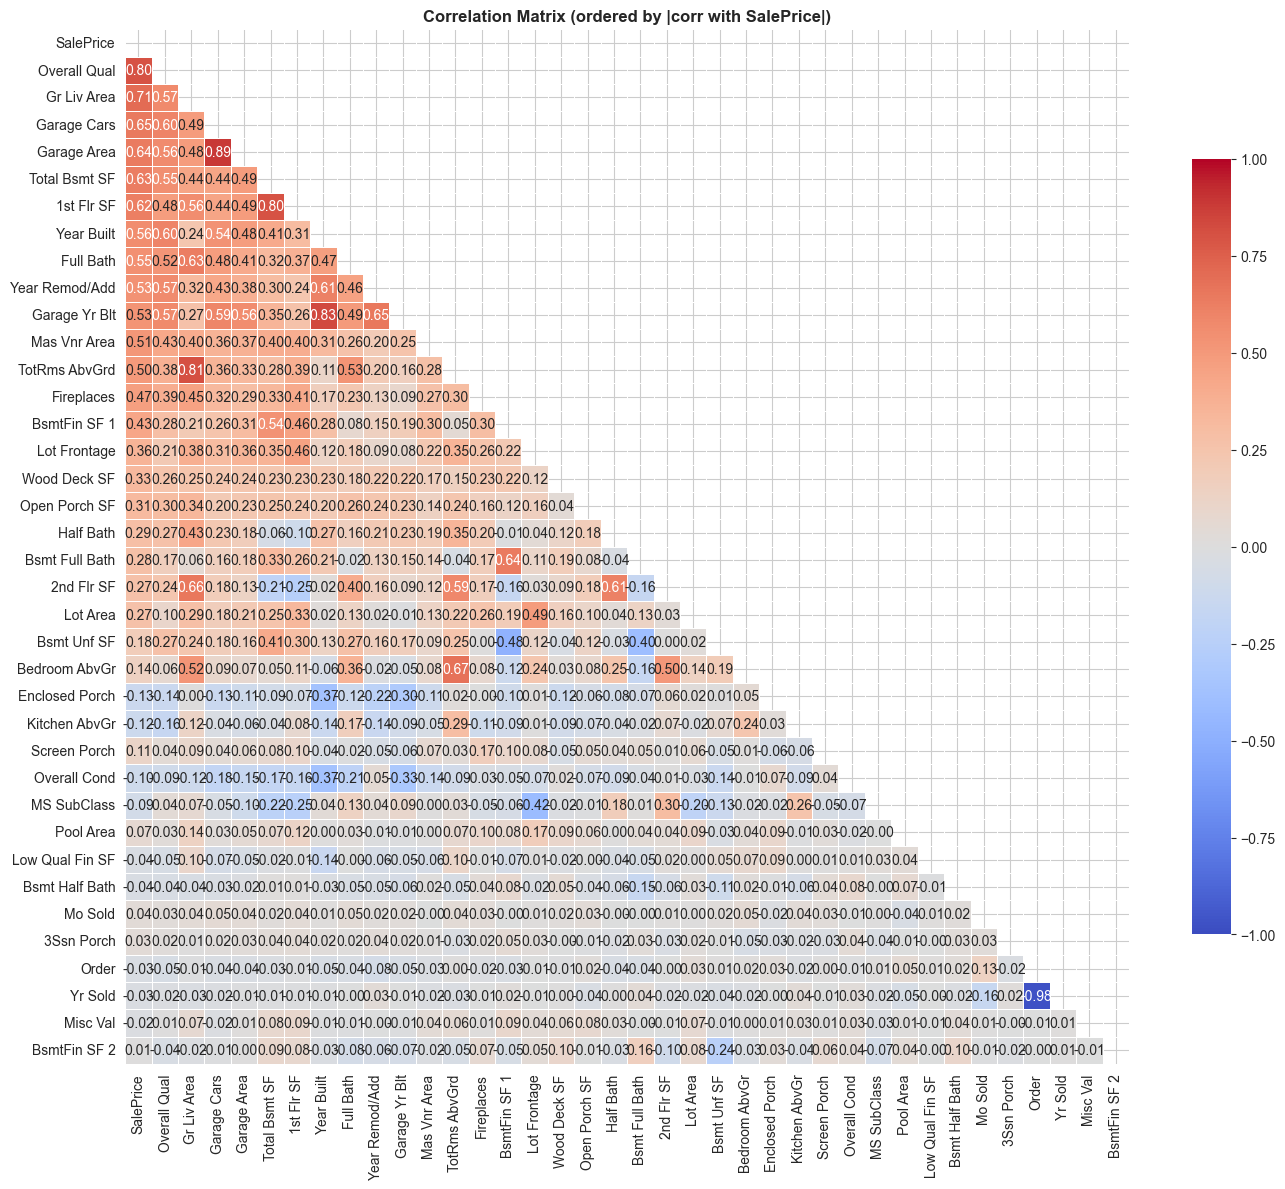

In [25]:
numerical_cols = ames_data.select_dtypes(include=[np.number]).columns.tolist()
if 'PID' in numerical_cols:
	numerical_cols.remove('PID')

# Ensure the target is not duplicated in the selected columns
if 'SalePrice' in numerical_cols:
	numerical_features = [c for c in numerical_cols if c != 'SalePrice']
else:
	numerical_features = numerical_cols.copy()

print(f"Total numerical features (excluding target): {len(numerical_features)}")

# Compute correlations between features and SalePrice (keep for reference)
correlations = ames_data[numerical_features + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)
print(f"\nTop 15 Correlations with SalePrice:")
print(correlations.head(15))

# Correlation matrix (include SalePrice) and order by |correlation with SalePrice|
cols = numerical_features + ['SalePrice']
corr_matrix = ames_data[cols].corr()
order = corr_matrix['SalePrice'].abs().sort_values(ascending=False).index.tolist()
corr_matrix = corr_matrix.loc[order, order]

# Visualize heatmap (mask upper triangle for readability)
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt='.2f',
			linewidths=.5, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix (ordered by |corr with SalePrice|)', fontweight='bold')
plt.tight_layout()
plt.show()

The heatmap reveals that 'Overall Quality' (0.80) and 'Gr Liv Area' (0.71) have the strongest positive impact on the final price. Conversely, features like 'Bsmt Half Bath' or 'Mo Sold' (Month Sold) show almost no correlation, suggesting they are less important for prediction.

## Key Features Relationships

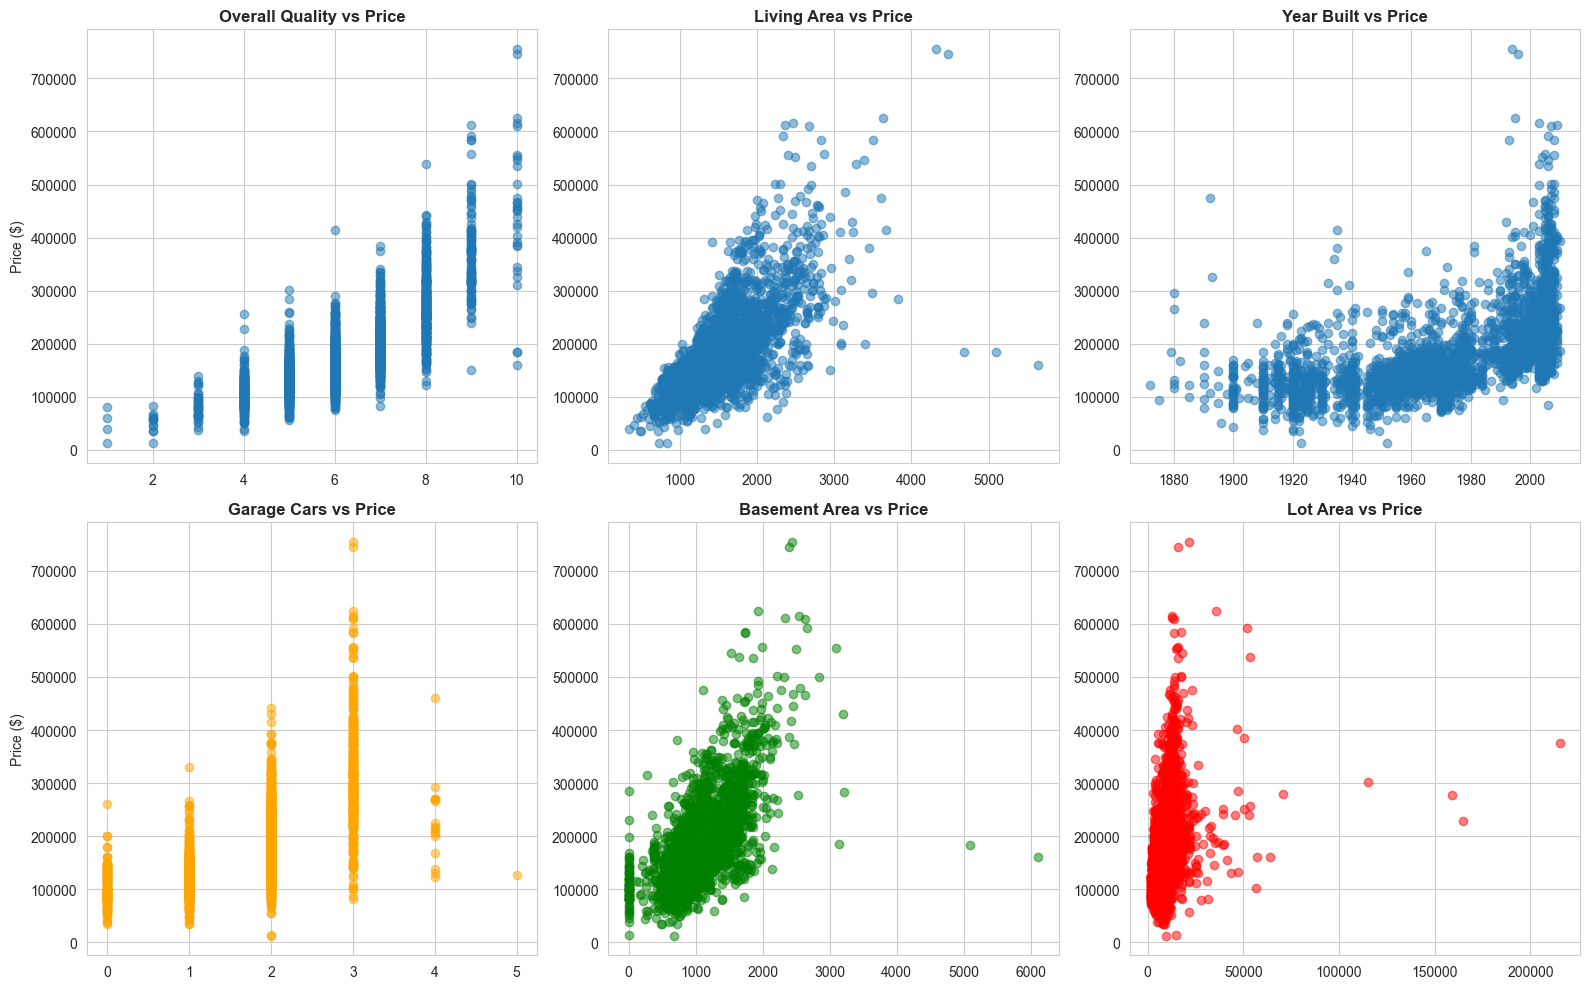

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Overall Quality
axes[0, 0].scatter(ames_data['Overall Qual'], ames_data['SalePrice'], alpha=0.5)
axes[0, 0].set_title('Overall Quality vs Price', fontweight='bold')
axes[0, 0].set_ylabel('Price ($)')

# Living Area
axes[0, 1].scatter(ames_data['Gr Liv Area'], ames_data['SalePrice'], alpha=0.5)
axes[0, 1].set_title('Living Area vs Price', fontweight='bold')

# Year Built
axes[0, 2].scatter(ames_data['Year Built'], ames_data['SalePrice'], alpha=0.5)
axes[0, 2].set_title('Year Built vs Price', fontweight='bold')

# Garage Cars
axes[1, 0].scatter(ames_data['Garage Cars'], ames_data['SalePrice'], alpha=0.5, color='orange')
axes[1, 0].set_title('Garage Cars vs Price', fontweight='bold')
axes[1, 0].set_ylabel('Price ($)')

# Total Basement
axes[1, 1].scatter(ames_data['Total Bsmt SF'], ames_data['SalePrice'], alpha=0.5, color='green')
axes[1, 1].set_title('Basement Area vs Price', fontweight='bold')

# Lot Area
axes[1, 2].scatter(ames_data['Lot Area'], ames_data['SalePrice'], alpha=0.5, color='red')
axes[1, 2].set_title('Lot Area vs Price', fontweight='bold')

plt.tight_layout()
plt.show()

These plots demonstrate clear linear relationships: as the Quality, Living Area, and Year Built increase, the price rises consistently. However, the 'Living Area' graph reveals a few outliers (huge houses with low prices) that should likely be removed to prevent confusing the model.

## Categorical Features Summary

In [32]:
categorical_cols = ames_data.select_dtypes(include=['object']).columns.tolist()
print(f"Total categorical features: {len(categorical_cols)}")

cardinality = [(col, ames_data[col].nunique()) for col in categorical_cols]
cardinality.sort(key=lambda x: x[1], reverse=True)
print(f"\nTop 20 Categorical Features by Cardinality:")
for col, count in cardinality[:20]:
    print(f"  {col}: {count} unique values")

Total categorical features: 43

Top 20 Categorical Features by Cardinality:
  Neighborhood: 28 unique values
  Exterior 2nd: 17 unique values
  Exterior 1st: 16 unique values
  Sale Type: 10 unique values
  Condition 1: 9 unique values
  Condition 2: 8 unique values
  House Style: 8 unique values
  Roof Matl: 8 unique values
  Functional: 8 unique values
  MS Zoning: 7 unique values
  Roof Style: 6 unique values
  Foundation: 6 unique values
  BsmtFin Type 1: 6 unique values
  BsmtFin Type 2: 6 unique values
  Heating: 6 unique values
  Garage Type: 6 unique values
  Sale Condition: 6 unique values
  Lot Config: 5 unique values
  Bldg Type: 5 unique values
  Exter Cond: 5 unique values


## Neighborhood Analysis

Neighborhood
NoRidge    330319.126761
StoneBr    324229.196078
NridgHt    322018.265060
GrnHill    280000.000000
Veenker    248314.583333
Timber     246599.541667
Somerst    229707.324176
ClearCr    208662.090909
Crawfor    207550.834951
CollgCr    201803.434457
Blmngtn    196661.678571
Greens     193531.250000
Gilbert    190646.575758
NWAmes     188406.908397
SawyerW    184070.184000
Name: SalePrice, dtype: float64


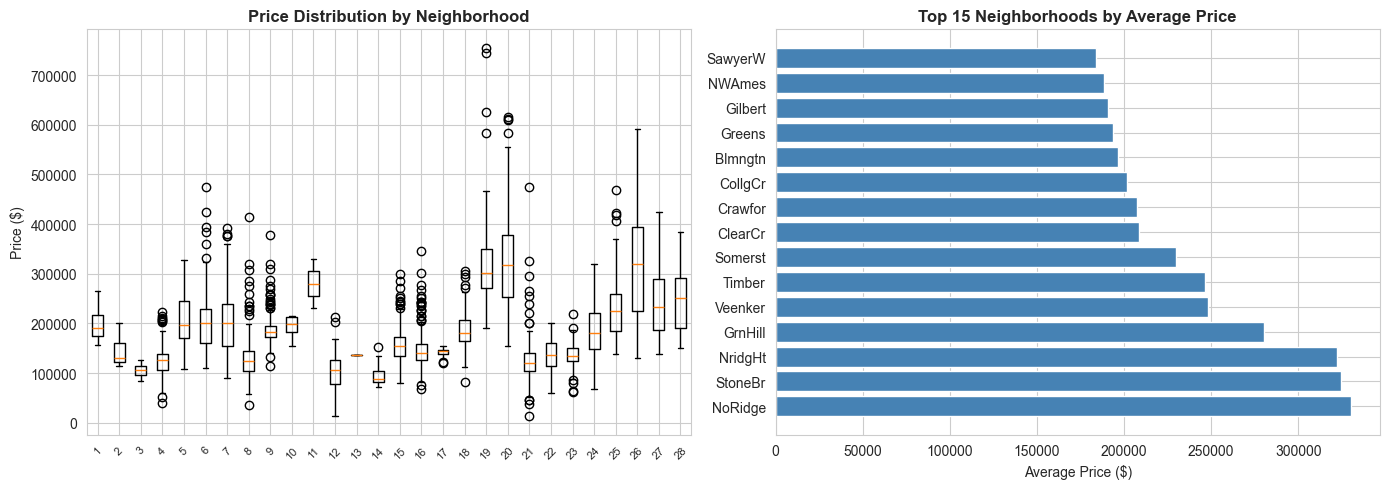

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

print(avg_by_neighborhood.head(15))

# Box plot by neighborhood
neighborhood_prices = ames_data.groupby('Neighborhood')['SalePrice'].apply(list)
axes[0].boxplot(neighborhood_prices.values)
axes[0].set_title('Price Distribution by Neighborhood', fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].tick_params(axis='x', rotation=45, labelsize=8)

# Average price by neighborhood
avg_by_neighborhood = ames_data.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False)
axes[1].barh(avg_by_neighborhood.index[:15], avg_by_neighborhood.values[:15], color='steelblue')
axes[1].set_title('Top 15 Neighborhoods by Average Price', fontweight='bold')
axes[1].set_xlabel('Average Price ($)')

plt.tight_layout()
plt.show()

The box plots prove that location is a massive price driver, with prime areas like 'NoRidge' and 'StoneBr' commanding significantly higher prices than others. Interestingly, expensive neighbourhoods also show much higher price variance (taller boxes) compared to affordable areas, which are very consistent.

## Ames Dataset EDA Summary

In [38]:
print("AMES DATASET - EDA SUMMARY")
print(f"\nTotal Samples: {len(ames_data):,}")
print(f"Total Features: {len(ames_data.columns)}")
print(f"Numerical: {ames_data.select_dtypes(include=[np.number]).shape}")
print(f"Categorical: {ames_data.select_dtypes(include=['object']).shape}")
print(f"\nTarget (SalePrice):")
print(f"  Mean: ${ames_data['SalePrice'].mean():,.0f}")
print(f"  Median: ${ames_data['SalePrice'].median():,.0f}")
print(f"  Range: ${ames_data['SalePrice'].min():,.0f} - ${ames_data['SalePrice'].max():,.0f}")
print(f"\nMissing Data: {ames_data.isnull().sum().sum()} values")
print(f"Neighborhoods: {ames_data['Neighborhood'].nunique()} unique areas")

AMES DATASET - EDA SUMMARY

Total Samples: 2,930
Total Features: 82
Numerical: (2930, 39)
Categorical: (2930, 43)

Target (SalePrice):
  Mean: $180,796
  Median: $160,000
  Range: $12,789 - $755,000

Missing Data: 15749 values
Neighborhoods: 28 unique areas
